In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from qualitative_analysis.data_processing import load_data, clean_and_normalize, sanitize_dataframe
from qualitative_analysis.model_interaction import get_llm_client
from qualitative_analysis.evaluation import compute_all_kappas
from qualitative_analysis.utils import save_results_to_csv, load_results_from_csv
import qualitative_analysis.config as config
from qualitative_analysis.prompt_construction import build_data_format_description
from qualitative_analysis.notebooks_functions import process_verbatims

In [2]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [3]:
# Define the path to your dataset
data_file_path = os.path.join(data_dir, 'multiclass_KA2.csv')

# Load the data
data = load_data(data_file_path, file_type='csv', delimiter=';')

# Preview the data
data.head()

,q_index,text,question,div_rater1,div_rater2,div_rater3
0,196,Les énormes yeux des insectes font quasiment l...,Pourquoi ces petits yeux sont chargés de trait...,2,2,2
1,197,Les énormes yeux des insectes font quasiment l...,Comment les point sont ensuite assemblés,2,2,0
2,198,Les énormes yeux des insectes font quasiment l...,C'est quoi un casque de vision 3D ?,2,2,2
3,199,Les énormes yeux des insectes font quasiment l...,Combien d'yeux petits ont les humains en moyen...,2,2,2
4,200,Les énormes yeux des insectes font quasiment l...,Quel être vivant a le plus de petis yeux ?,1,1,2


In [4]:
# 1) Define a mapping from old column names to new names
# rename_map = {
#     "ref": "reference",
#     "txt1.ctrl1": "Identify",
#     "txt1.det": "Guess",
#     "txt1.exp": "Seek",
#     "txt1.ctrl2": "Assess"
# }

# # 2) Rename the columns in the DataFrame
# data = data.rename(columns=rename_map)

# 3) Now define the new column names for cleaning
text_columns = ["text", "question"]

# 4) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 5) Sanitize the DataFrame
data = sanitize_dataframe(data)


c:\Users\ocler\Documents\Académique\Inria\qualitative_analysis_project\qualitative_analysis\data_processing.py:134: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [5]:
# Combine texts and entries

data['verbatim'] = data.apply(
    lambda row: (
        f"Text: {row['text']}\n\n"
        f"Question: {row['question']}"
    ),
    axis=1
)

# Extract the list of verbatims
verbatims = data['verbatim'].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 107
Verbatim example:
Text: Les énormes yeux des insectes font quasiment le tour de leurs têtes. Ils voient donc en même temps vers l’avant, vers l’arrière, à droite, à gauche, vers le haut et vers le bas. Encore mieux qu’un casque de vision en 3D! En revanche, ils ne voient pas très net, parce que leur œil est constitué de centaines, ou même de milliers de petits yeux simples. Chacun de ces petits yeux est chargé de traiter une toute petite partie de l’environnement. Un petit œil produit un simple point d’une teinte et d’une intensité lumineuse données. Ces points sont ensuite assemblés les uns aux autres dans le cerveau de l’insecte pour former une image complète et unique. Un œil d’une abeille contient 4500 petits yeux. Celui d’une libellule en a 15000: c’est l'œil le plus complexe chez les insectes !

Question: Pourquoi ces petits yeux sont chargés de traiter une petite partie de l'environnement ?


In [6]:
# Choose the provider and model
provider = 'azure'
model_name = 'gpt-4o-mini'

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

In [10]:
# Define column descriptions
column_descriptions = {
    "Texte": "Le texte de référence",
    "Question": "Le texte de référence que les participants doivent lire au préalable. La question doit être sémantiquement liée à ce texte (même sujet), mais la réponse à la question posée ne doit pas se trouver dans le texte."
}

# Define instructions for multiclass classification
theme_name = "Classification de divergence"
theme_description = """
Les données se composent d'un texte de référence et d'une question posée par un enfant.
Vous devez classer la question dans l'une des catégories suivantes :

0 : la réponse à la question est indiquée dans le texte.
1 : la réponse à la question n'est pas explicitement indiquée dans le texte, mais peut être déduite ou devinée à partir du texte.
2 : la réponse à la question n'est pas du tout indiquée dans le texte.

Votre réponse ne doit comporter que le chiffre de la classification, pas de texte, pas d'autres caractères, pas d'explication.
Les erreurs mineures d'orthographe, de grammaire ou de formulation ne doivent pas être pénalisées tant que l'intention de l'entrée est claire et respecte les critères d'inclusion. Concentrez-vous sur le contenu et l'objectif de l'entrée plutôt que sur la perfection linguistique.

Exemple 1
Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
Question: Quand est-elle née ?
Réponse: 2

Exemple 2
Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
Question: Marie a-t-elle passé toute sa vie en Pologne ?
Réponse: 0

Exemple 3
Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
Question: Qui est Pierre Curie ?
Réponse: 1
"""

data_format_description = build_data_format_description(column_descriptions)

# Classification settings
reasoning = False  # If True, perform two-step reasoning. If False, single-step classification.

# Define queries for multiclass classification and reasoning
multiclass_query = "Répondez uniquement avec un chiffre, rien d'autre. '0' si la réponse à la question est explicitement indiquée dans le texte, '1' si la réponse à la question n'est pas explicitement indiquée dans le texte mais peut être déduite ou devinée à partir du texte, ou '2' si la réponse à la question n'est pas du tout indiquée dans le texte."
reasoning_query = "Générez un raisonnement d'une seule phrase à propos de la classification (ne donnez pas le label de classification)."

# Define valid scores (modifiable in the notebook)
valid_scores = [0, 1, 2]  # You can change this to any list of valid scores

# Select subset of verbatims for testing
verbatims_subset = verbatims[:40]

# Define the prompt construction logic (keep this in the notebook)
def construct_prompt(verbatim, theme, theme_description, data_format_description):
    """
    Constructs the base prompt for the given verbatim and the multiclass classification scenario.
    """
    prompt = f"""
Vous êtes un assistant utile chargé d'évaluer l'entrée suivante.

Vous disposez de données présentées dans le format suivant :

{data_format_description}

**Entrée:**
{verbatim}

**Tâche:**
{theme} - {theme_description}
"""
    return prompt.strip()

# Process verbatims using the externalized function
results, verbatim_costs = process_verbatims(
    verbatims_subset=verbatims_subset,
    llm_client=llm_client,
    model_name=model_name,
    theme_name=theme_name,
    theme_description=theme_description,
    data_format_description=data_format_description,
    construct_prompt=construct_prompt,  # Pass the prompt construction function
    multiclass_query=multiclass_query,  # Pass multiclass_query
    reasoning_query=reasoning_query,    # Pass reasoning_query
    valid_scores=valid_scores,          # Pass valid_scores
    reasoning=reasoning,
    verbose=True
)

# Print final multiclass results
for result in results:
    print(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)


=== Processing Verbatim 1/40 ===

--- Evaluating Theme: Classification de divergence ---
=== Single-step Classification Prompt ===
Prompt:
Vous êtes un assistant utile chargé d'évaluer l'entrée suivante.

Vous disposez de données présentées dans le format suivant :

The data has the following columns:
- "Texte": Le texte de référence
- "Question": Le texte de référence que les participants doivent lire au préalable. La question doit être sémantiquement liée à ce texte (même sujet), mais la réponse à la question posée ne doit pas se trouver dans le texte.


**Entrée:**
Text: Les énormes yeux des insectes font quasiment le tour de leurs têtes. Ils voient donc en même temps vers l’avant, vers l’arrière, à droite, à gauche, vers le haut et vers le bas. Encore mieux qu’un casque de vision en 3D! En revanche, ils ne voient pas très net, parce que leur œil est constitué de centaines, ou même de milliers de petits yeux simples. Chacun de ces petits yeux est chargé de traiter une tou

In [11]:
# Possibility to save the results

# # Define the save path
# outputs_dir = os.path.join(data_dir, 'outputs')
# os.makedirs(outputs_dir, exist_ok=True)
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# save_path = os.path.join(outputs_dir, f"experiment_{model_name.replace('/', '_')}_{timestamp}.csv")

# # Save results
# save_results_to_csv(
#     coding=results_df.to_dict('records'),
#     save_path=save_path,
#     fieldnames=['Verbatim', 'Label'],
#     verbatims=None  # Verbatims are included in the results
# )

In [12]:
# Assuming you have human annotations in the data
model_coding = results_df['Label'].tolist()
model_coding = [int(x) for x in model_coding]

human_annotations = {
    'div_rater1': [int(x) for x in data['div_rater1'].tolist()],
    'div_rater2': [int(x) for x in data['div_rater2'].tolist()],
    'div_rater3': [int(x) for x in data['div_rater3'].tolist()],
}

# Shorten data for demonstration if needed
model_coding_short = model_coding[:40]
human_annotations_short = {rater: ann[:40] for rater, ann in human_annotations.items()}

# Compute Cohen's Kappa for all pairings and print results
kappa_results = compute_all_kappas(
    model_coding_short,
    human_annotations_short,
    labels=[0, 1, 2],
    weights='linear',
    verbose=True
)

Model vs div_rater1: 0.17
Model vs div_rater2: 0.17
Model vs div_rater3: 0.13
div_rater1 vs div_rater2: 1.00
div_rater1 vs div_rater3: 0.37
div_rater2 vs div_rater3: 0.37


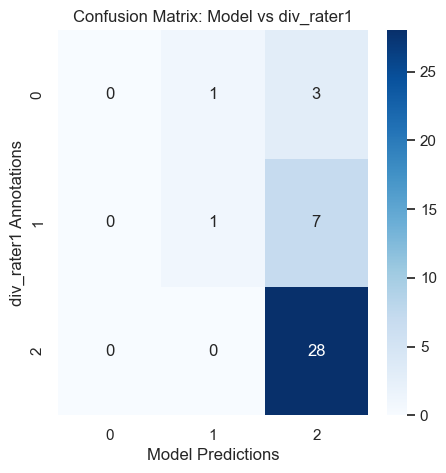

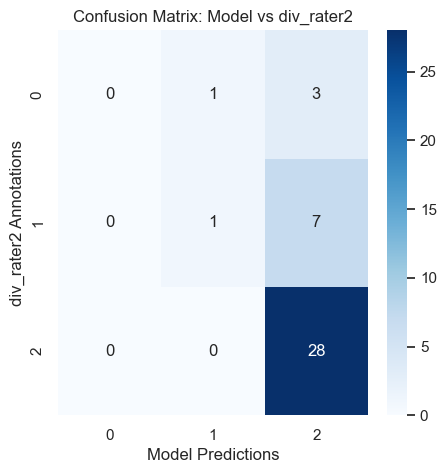

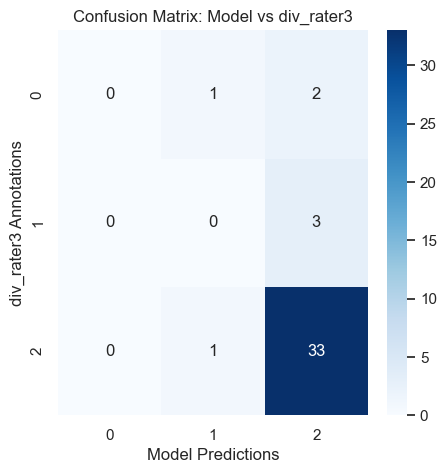

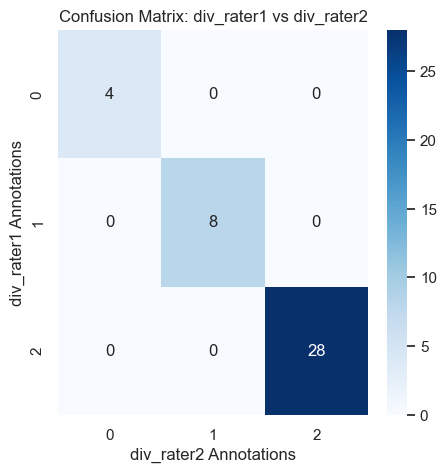

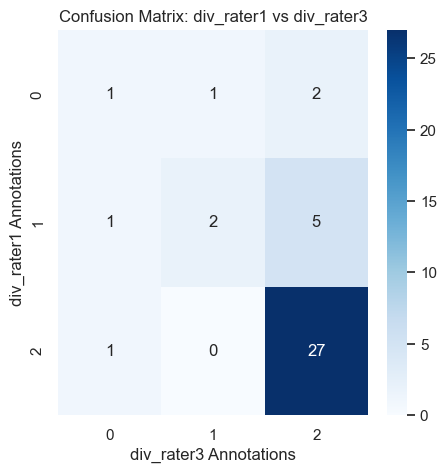

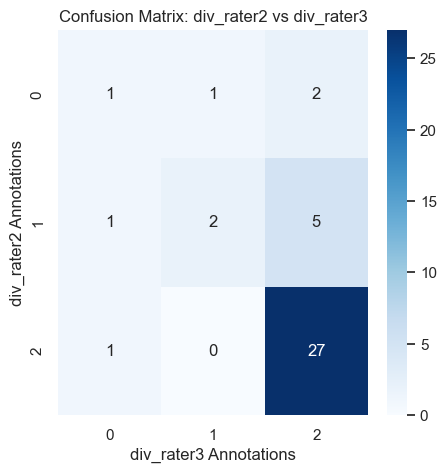

In [ ]:
def plot_confusion_matrices(model_coding, human_annotations, labels):
    """
    Plots confusion matrices for all combinations of model coding and human annotations,
    as well as between human annotations themselves, using Seaborn.

    Parameters:
        model_coding (list): List of model predictions.
        human_annotations (dict): Dictionary where keys are rater names and values are lists of annotations.
        labels (list): List of labels to index the confusion matrix.
    """
    sns.set(style="whitegrid")  # Set the style of the plots

    # Compare model with each human rater
    for rater, annotations in human_annotations.items():
        cm = confusion_matrix(annotations, model_coding, labels=labels)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f"Confusion Matrix: Model vs {rater}")
        plt.xlabel('Model Predictions')
        plt.ylabel(f'{rater} Annotations')
        plt.show()

    # Compare each human rater with every other human rater
    raters = list(human_annotations.keys())
    for i in range(len(raters)):
        for j in range(i + 1, len(raters)):
            rater1, rater2 = raters[i], raters[j]
            cm = confusion_matrix(human_annotations[rater1], human_annotations[rater2], labels=labels)
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
            plt.title(f"Confusion Matrix: {rater1} vs {rater2}")
            plt.xlabel(f'{rater2} Annotations')
            plt.ylabel(f'{rater1} Annotations')
            plt.show()

# Example Usage
# Plot confusion matrices for all comparisons
plot_confusion_matrices(model_coding_short, human_annotations_short, labels=[0, 1, 2])